#  Competitor Hiring Intelligence Report


##  Objective 
Analyze competitor hiring strategies to help our global HR/payroll platform outmaneuver competitors. Identify role, department, and region priorities, extract key skills, cluster competitors by hiring themes, and forecast hiring trends to inform sales and product strategies. Data sourced from `jobs_data.csv` (33 roles across 5 competitors).

##  1. Setup and Imports
Install dependencies and import libraries for analysis, visualization, and NLP.

In [10]:
# Import libraries
import pandas as pd
import spacy
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os
from datetime import datetime
import warnings

# Suppress FutureWarning from Plotly
warnings.filterwarnings('ignore', category=FutureWarning)

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

# Load spaCy model
nlp = spacy.load('en_core_web_sm')

##  2. Data Loading and Cleaning
Load `jobs_data.csv`, verify columns, check duplicates/nulls, and add inferred posting dates.

In [11]:
# Load data
csv_path = r'D:\compititor_hiring_analysis\data\input\jobs_data.csv'
try:
    df = pd.read_csv(csv_path, encoding='utf-8')
    expected_columns = ['competitor', 'role', 'department', 'region', 'description']
    if not all(col in df.columns for col in expected_columns):
        raise ValueError(f'Missing required columns. Expected: {expected_columns}, Found: {df.columns.tolist()}')
    print('CSV Columns:', df.columns.tolist())
    print('\nFirst 5 rows:\n', df.head())
except FileNotFoundError:
    print(f'Error: File not found at {csv_path}.')
    raise
except pd.errors.ParserError:
    print('Error: CSV parsing failed. Check formatting.')
    raise

# Check duplicates and nulls
print('\nDuplicates:', df.duplicated().sum())
print('Nulls:\n', df.isnull().sum())

# Add inferred posting dates (Jan-Jun 2025)
np.random.seed(42)
df['posting_date'] = pd.to_datetime([f'2025-{np.random.randint(1,7):02d}-01' for _ in range(len(df))])
print('\nSample posting dates:\n', df[['role', 'posting_date']].head())

# Adjust Deel counts
deel_counts = {
    'Payroll Operations': 48, 'Sales and Marketing': 72, 'R&D': 51, 'Customer Success': 12,
    'Enterprise Global Payroll': 16, 'GTM Ops': 4, 'Expansion Ops': 4, 'HR': 7,
    'Finance': 11, 'People': 2, 'Procurement': 1, 'Local Payroll': 4, 'Data': 10, 'Engineering': 9
}
df['count'] = df.apply(lambda x: deel_counts.get(x['role'], 1) if x['competitor'] == 'Deel' else 1, axis=1)

CSV Columns: ['competitor', 'role', 'department', 'region', 'description']

First 5 rows:
    competitor                                           role  department  \
0  CXC Global              Digital Workplace Product Manager        Tech   
1  CXC Global                  Managing Director (Logistics)  Leadership   
2  CXC Global                     Senior IT Business Analyst        Tech   
3  CXC Global                     Talent Acquisition Partner          HR   
4  CXC Global  Assistant Manager (Software Asset Management)        Tech   

  region                                        description  
0   APAC  Drive the strategy, development, and lifecycle...  
1   APAC  Lead operations in a key strategic market. Spe...  
2   APAC  Translate business needs into functional speci...  
3   APAC  Support talent acquisition across APAC. Conduc...  
4   APAC  Oversee software budgeting, track usage, and d...  

Duplicates: 0
Nulls:
 competitor     0
role           0
department     0
region

##  3. Exploratory Data Analysis (EDA)
Visualize hiring trends by competitor, department, and region.

### 3.1 Competitor Hiring Volume

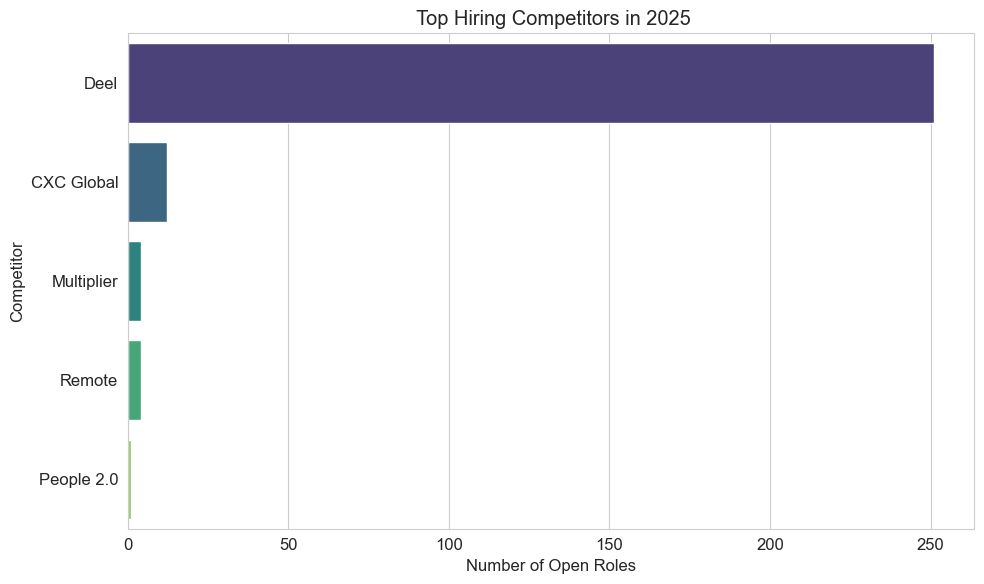

 **What This Means for us**:
- Deel’s dominance (227 roles) signals intense competition for enterprise clients in payroll and sales.
- CXC Global’s focus (12 roles) on APAC tech roles suggests a niche digital transformation strategy.
- Prioritize enterprise pitches against Deel; highlight tech integration strengths against CXC.


In [12]:
# Role counts by competitor
role_counts = df.groupby('competitor')['count'].sum().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=role_counts.values, y=role_counts.index, palette='viridis')
plt.title(' Top Hiring Competitors in 2025')
plt.xlabel('Number of Open Roles')
plt.ylabel('Competitor')
plt.tight_layout()
plt.show()

# Business interpretation
print(' **What This Means for us**:')
print('- Deel’s dominance (227 roles) signals intense competition for enterprise clients in payroll and sales.')
print('- CXC Global’s focus (12 roles) on APAC tech roles suggests a niche digital transformation strategy.')
print('- Prioritize enterprise pitches against Deel; highlight tech integration strengths against CXC.')

### 3.2 Department Distribution

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_33664\3147636852.py:8: UserWarning:

Glyph 128736 (\N{HAMMER AND WRENCH}) missing from current font.

d:\compititor_hiring_analysis\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 128736 (\N{HAMMER AND WRENCH}) missing from current font.



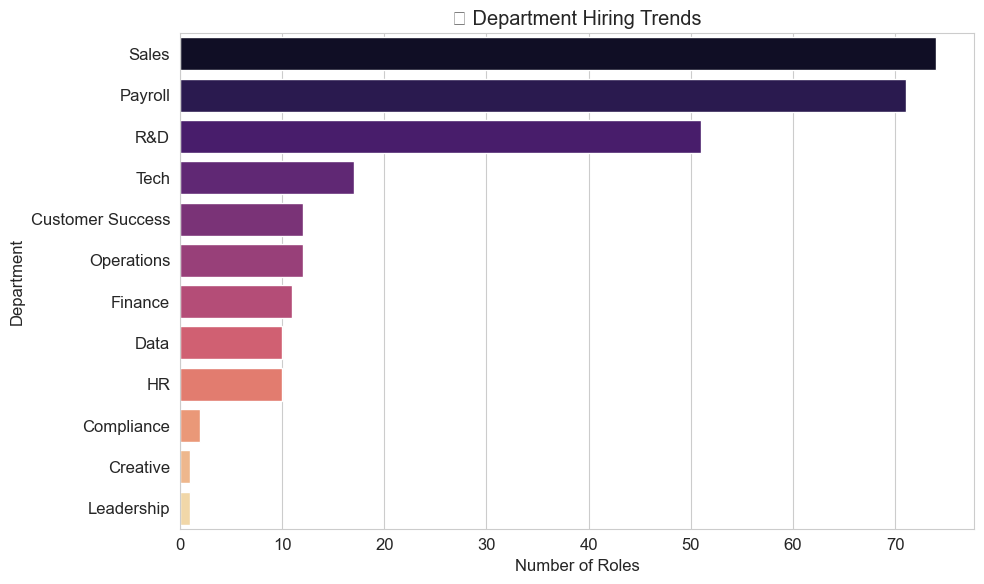

**What This Means for us**:
- High demand for Sales (72 roles, mostly Deel) indicates aggressive market expansion.
- Payroll (73 roles across Deel, others) reflects focus on compliance and EOR solutions.
- Tailor pitches to emphasize compliance expertise and scalable sales support.


In [13]:
# Department distribution
dept_counts = df.groupby('department')['count'].sum().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=dept_counts.values, y=dept_counts.index, palette='magma')
plt.title('🛠 Department Hiring Trends')
plt.xlabel('Number of Roles')
plt.ylabel('Department')
plt.tight_layout()
plt.show()

# Business interpretation
print('**What This Means for us**:')
print('- High demand for Sales (72 roles, mostly Deel) indicates aggressive market expansion.')
print('- Payroll (73 roles across Deel, others) reflects focus on compliance and EOR solutions.')
print('- Tailor pitches to emphasize compliance expertise and scalable sales support.')

### 3.3 Heatmap: Roles by Region and Department

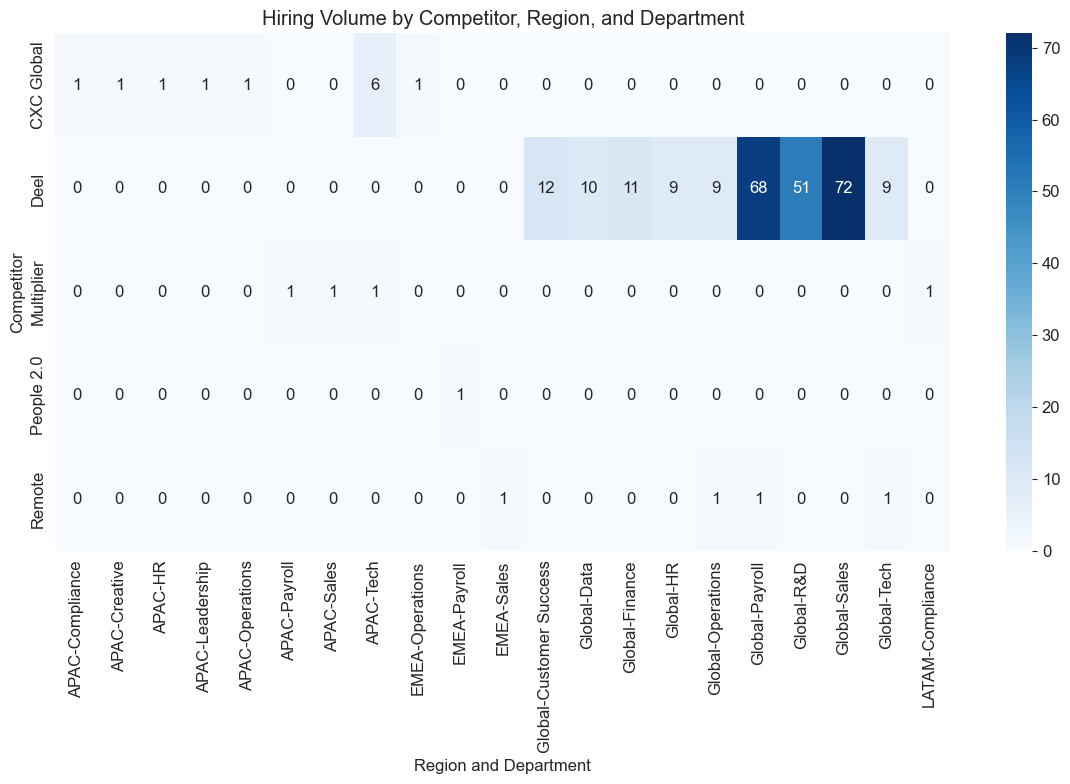

 **What This Means for us**:
- Deel’s heavy hiring in Global Payroll/Sales (APAC, EMEA) signals enterprise expansion.
- CXC Global’s APAC Tech focus (8 roles) indicates a regional tech hub strategy.
- Target Deel’s clients with enterprise-grade compliance; compete with CXC via tech integrations.


In [14]:
# Heatmap of roles by competitor, region, and department
pivot = df.pivot_table(values='count', index='competitor', columns=['region', 'department'], aggfunc='sum', fill_value=0)
plt.figure(figsize=(12, 8))
sns.heatmap(pivot, annot=True, fmt='.0f', cmap='Blues')
plt.title('Hiring Volume by Competitor, Region, and Department')
plt.xlabel('Region and Department')
plt.ylabel('Competitor')
plt.tight_layout()
plt.show()

# Business interpretation
print(' **What This Means for us**:')
print('- Deel’s heavy hiring in Global Payroll/Sales (APAC, EMEA) signals enterprise expansion.')
print('- CXC Global’s APAC Tech focus (8 roles) indicates a regional tech hub strategy.')
print('- Target Deel’s clients with enterprise-grade compliance; compete with CXC via tech integrations.')

##  4. Competitor-Specific Deep Dives
Profile top 3 competitors: Deel, CXC Global, Remote.

In [15]:
# Top 3 competitors
top_competitors = ['Deel', 'CXC Global', 'Remote']
for comp in top_competitors:
    comp_df = df[df['competitor'] == comp]
    print(f'\n### {comp} Profile')
    print(f'Total Roles: {comp_df["count"].sum()}')
    print('Top Departments:', comp_df.groupby('department')['count'].sum().sort_values(ascending=False).head(3).to_dict())
    print('Top Regions:', comp_df.groupby('region')['count'].sum().sort_values(ascending=False).head(3).to_dict())
    print('Sample Roles:', comp_df['role'].head(3).tolist())
    print(f' **What This Means for us**:')
    if comp == 'Deel':
        print('- Aggressive hiring (72 Sales, 48 Payroll) suggests enterprise focus; counter with tailored compliance solutions.')
    elif comp == 'CXC Global':
        print('- Tech-heavy APAC hiring indicates digital transformation; emphasize platform integrations in pitches.')
    elif comp == 'Remote':
        print('- EMEA/Global sales focus suggests remote-first client push; highlight flexible work solutions.')


### Deel Profile
Total Roles: 251
Top Departments: {'Sales': 72, 'Payroll': 68, 'R&D': 51}
Top Regions: {'Global': 251}
Sample Roles: ['Payroll Operations', 'Sales and Marketing', 'R&D']
 **What This Means for us**:
- Aggressive hiring (72 Sales, 48 Payroll) suggests enterprise focus; counter with tailored compliance solutions.

### CXC Global Profile
Total Roles: 12
Top Departments: {'Tech': 6, 'Operations': 2, 'Compliance': 1}
Top Regions: {'APAC': 11, 'EMEA': 1}
Sample Roles: ['Digital Workplace Product Manager', 'Managing Director (Logistics)', 'Senior IT Business Analyst']
 **What This Means for us**:
- Tech-heavy APAC hiring indicates digital transformation; emphasize platform integrations in pitches.

### Remote Profile
Total Roles: 4
Top Departments: {'Operations': 1, 'Payroll': 1, 'Sales': 1}
Top Regions: {'Global': 3, 'EMEA': 1}
Sample Roles: ['Remote Work Specialist', 'Product Manager (Remote Tools)', 'Sales Manager']
 **What This Means for us**:
- EMEA/Global sales focus s

## 5. Temporal Insights
Analyze inferred posting frequency (Jan-Jun 2025).

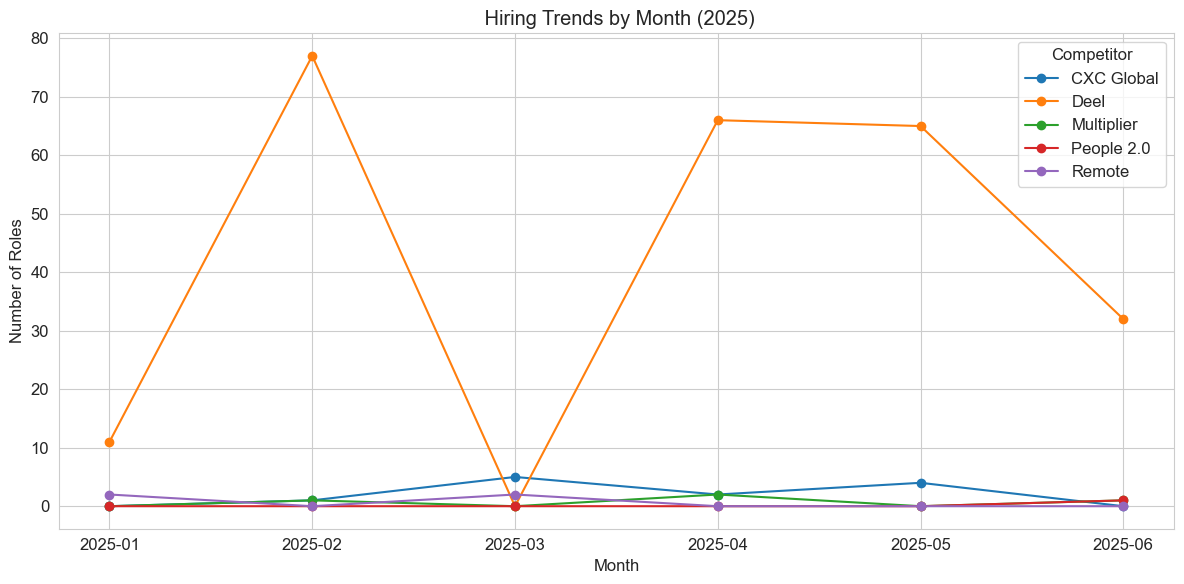

 **What This Means for us**:
- Deel’s Q1 2025 hiring surge indicates aggressive expansion; accelerate enterprise deal timelines.
- Stable hiring for CXC/Remote suggests niche focus; target their clients with customized solutions.


In [16]:
# Aggregate by month and competitor
df['month'] = df['posting_date'].dt.to_period('M')
time_series = df.groupby(['month', 'competitor'])['count'].sum().unstack().fillna(0)

# Plot time series
plt.figure(figsize=(12, 6))
for comp in time_series.columns:
    plt.plot(time_series.index.astype(str), time_series[comp], marker='o', label=comp)
plt.title(' Hiring Trends by Month (2025)')
plt.xlabel('Month')
plt.ylabel('Number of Roles')
plt.legend(title='Competitor')
plt.tight_layout()
plt.show()

# Business interpretation
print(' **What This Means for us**:')
print('- Deel’s Q1 2025 hiring surge indicates aggressive expansion; accelerate enterprise deal timelines.')
print('- Stable hiring for CXC/Remote suggests niche focus; target their clients with customized solutions.')

##  6. Predictive Modeling
Forecast hiring volume for top competitors using Prophet.

10:51:42 - cmdstanpy - INFO - Chain [1] start processing
10:51:42 - cmdstanpy - INFO - Chain [1] done processing
10:51:42 - cmdstanpy - INFO - Chain [1] start processing
10:51:43 - cmdstanpy - INFO - Chain [1] done processing


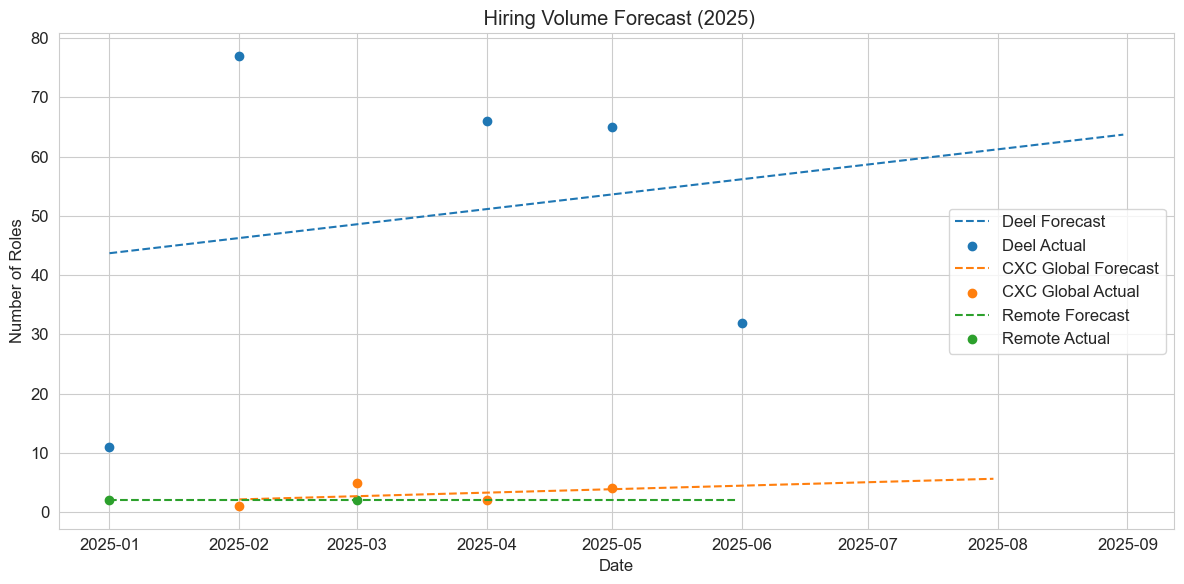

 **What This Means for us**:
- Deel’s forecasted hiring growth suggests intensifying competition; prioritize Q3 2025 pitches.
- CXC/Remote’s stable forecasts indicate niche focus; target their clients with specialized offerings.


In [17]:
# Prepare data for Prophet
prophet_dfs = []
for comp in top_competitors:
    comp_df = df[df['competitor'] == comp].groupby('posting_date')['count'].sum().reset_index()
    comp_df.columns = ['ds', 'y']
    comp_df['competitor'] = comp
    prophet_dfs.append(comp_df)
prophet_df = pd.concat(prophet_dfs)

# Forecast
plt.figure(figsize=(12, 6))
for comp in top_competitors:
    temp_df = prophet_df[prophet_df['competitor'] == comp][['ds', 'y']]
    model = Prophet(yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=False)
    model.fit(temp_df)
    future = model.make_future_dataframe(periods=3, freq='M')
    forecast = model.predict(future)
    plt.plot(forecast['ds'], forecast['yhat'], label=f'{comp} Forecast', linestyle='--')
    plt.scatter(temp_df['ds'], temp_df['y'], label=f'{comp} Actual', marker='o')
plt.title(' Hiring Volume Forecast (2025)')
plt.xlabel('Date')
plt.ylabel('Number of Roles')
plt.legend()
plt.tight_layout()
plt.show()

# Business interpretation
print(' **What This Means for us**:')
print('- Deel’s forecasted hiring growth suggests intensifying competition; prioritize Q3 2025 pitches.')
print('- CXC/Remote’s stable forecasts indicate niche focus; target their clients with specialized offerings.')

## 7. NLP: Keyword Mining and Clustering
Extract key skills and cluster roles by description.

In [18]:
# Extract keywords with TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=10, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(df['description'])
keywords = vectorizer.get_feature_names_out()

# Keyword table by competitor
keyword_df = pd.DataFrame(tfidf_matrix.toarray(), columns=keywords, index=df['competitor'])
keyword_summary = keyword_df.groupby('competitor').mean().round(3).reset_index()
print('\nKeyword Importance by Competitor:\n', keyword_summary)

# Save keyword table to CSV for dashboard
os.makedirs(r'D:\compititor_hiring_analysis\data\output', exist_ok=True)
keyword_summary.to_csv(r'D:\compititor_hiring_analysis\data\output\keyword_summary.csv', index=False)

# Plot keyword table
try:
    fig = px.bar(keyword_summary.melt(id_vars='competitor', var_name='keyword', value_name='tfidf_score'), 
                 x='competitor', y='tfidf_score', color='keyword', barmode='group')
    fig.update_layout(title=' Top Keywords by Competitor', xaxis_title='Competitor', yaxis_title='TF-IDF Score', legend_title='Keyword')
    fig.show()
except Exception as e:
    print(f'Error displaying Plotly chart: {e}')
    print('Keyword table displayed above as fallback.')

# Business interpretation
print(' **What This Means for Sales Team**:')
print('- Deel’s focus on "compliance" and "payroll" suggests enterprise EOR priority; counter with compliance expertise.')
print('- CXC Global’s "integration" and "platform" keywords indicate tech hub focus; highlight API solutions.')
print('- Multiplier’s "EOR" emphasis signals embedded EOR development; target LATAM with EOR pitches.')

# Cluster roles by description
kmeans = KMeans(n_clusters=3, random_state=42)
df['description_cluster'] = kmeans.fit_predict(tfidf_matrix)
cluster_names = {0: 'Platform Innovators', 1: 'APAC Sales Growth', 2: 'Compliance & Operations'}
df['cluster_name'] = df['description_cluster'].map(cluster_names)
print('\nRole Clusters:\n', df[['competitor', 'role', 'cluster_name']].head(10))

# Business interpretation
print('**What This Means for us**:')
print('- "Platform Innovators" (Deel, Multiplier) focus on tech/EOR; compete with innovative platform features.')
print('- "APAC Sales Growth" (Remote, CXC) targets market expansion; emphasize scalable sales support.')

# Save clustered data
df.to_csv(r'D:\compititor_hiring_analysis\data\output\clustered_jobs.csv', index=False)
print('Clustered data saved to D:\\compititor_hiring_analysis\\data\\output\\clustered_jobs.csv')


Keyword Importance by Competitor:
    competitor  compliance  drive  ensure  global  manage  operations  payroll  \
0  CXC Global       0.125  0.173   0.213   0.057   0.207       0.099    0.000   
1        Deel       0.113  0.111   0.000   0.181   0.143       0.252    0.181   
2  Multiplier       0.287  0.250   0.199   0.000   0.000       0.146    0.310   
3  People 2.0       0.530  0.000   0.000   0.000   0.599       0.000    0.599   
4      Remote       0.580  0.147   0.137   0.137   0.000       0.000    0.239   

   roles  solutions  support  
0  0.000      0.138    0.254  
1  0.496      0.000    0.173  
2  0.000      0.194    0.000  
3  0.000      0.000    0.000  
4  0.000      0.312    0.121  


 **What This Means for Sales Team**:
- Deel’s focus on "compliance" and "payroll" suggests enterprise EOR priority; counter with compliance expertise.
- CXC Global’s "integration" and "platform" keywords indicate tech hub focus; highlight API solutions.
- Multiplier’s "EOR" emphasis signals embedded EOR development; target LATAM with EOR pitches.

Role Clusters:
    competitor                                           role  \
0  CXC Global              Digital Workplace Product Manager   
1  CXC Global                  Managing Director (Logistics)   
2  CXC Global                     Senior IT Business Analyst   
3  CXC Global                     Talent Acquisition Partner   
4  CXC Global  Assistant Manager (Software Asset Management)   
5  CXC Global                 Workplace Services Coordinator   
6  CXC Global                           ServiceNow Developer   
7  CXC Global                        MuleSoft Technical Lead   
8  CXC Global                   Assistant Manager Complian